In [68]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

In [69]:
import datasets
from os.path import join
import tensorflow as tf
import torch

In [70]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
params_files = []

In [71]:
bert_model_name= 'google/bert_uncased_L-2_H-128_A-2'

In [72]:
import sys
sys.path.append("../")
from data.manual_labels.data_reader import ManualLabels

In [73]:
from features_processing.bert_tokenizer import BERTTokenizer

## Load Data

In [197]:
data =[{'id':'any_cancer_IMPRESS','type': 'manual_label' , 'params': {'outcome': 'any_cancer', 'text': 'NARR+IMPRESS'}}]
data = ManualLabels(**data[0]['params'])
x_train, x_validate, x_test, y_train, y_validate, y_test, info_train, info_validate, info_test, columns = data.get_train_validate_test()

(8104, 16) (8104,)


In [198]:
print (x_train.shape)
print (x_validate.shape)
print (x_test.shape)

(6409,)
(782,)
(913,)


## preprocessing

In [199]:
import re

from sklearn.base import BaseEstimator


def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
#     sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub('[^0-9a-zA-Z:,]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

class CleanText(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X):
        pass

    def transform(self,X, y='deprecated', copy=None):
        reviews = []
        sentences = list(X)
        for sen in sentences:
            reviews.append(preprocess_text(sen))
        return np.array(reviews)


In [200]:
x_train.shape

(6409,)

In [201]:
proc= CleanText()
x_test =proc.transform(x_test)
x_validate =proc.transform(x_validate)
x_train =proc.transform(x_train)

In [202]:
len(x_test)

913

In [203]:
type(cleaned)

numpy.ndarray

In [204]:
x_test[0]

'exam number: a12214162 report status: final type: abd ct contrast 6026 date time: 09 14 2012 09:38 exam code: 6026 ordering provider: jackman md, david associated reports: a12326033: df 100 ml contrast a12326032: chest ct contrast 6023 report: indication: nonsmall cell lung cancer, restaging technique: ct of the chest and abdomen was performed following the administration of both oral and 100 ml of nonionic intravenous contrast material ultravist 300 comparison: 7 17 2012 findings: chest: dominant left lower lobe mass has not significantly changed, measuring 3 0 1 4 cm on coronal images 6: 22 5 mm nodule along the left major fissure appears unchanged in size, however has more solid appearance 3: 30 unchanged 2 3 mm nodules scattered throughout the lungs 3: 30, 32, 35 biapical scarring is unchanged peripheral nodularity with associated groundglass opacity in the right upper lobe appears similar, 3: 11 13 loculated fluid in the left apex is again noted 2: 10 similar appearance of post t

## Tokenization

In [205]:
# tokenizer= BERTTokenizer(bert_model_name, True, True, 512)
tokenizer= BERTTokenizer(bert_model_name, False, False, None)

In [206]:
x_train_encoded = tokenizer.transform(list(x_train))
x_val_encoded = tokenizer.transform(list(x_validate))

type ret <class 'transformers.tokenization_utils_base.BatchEncoding'>
Encoding(num_tokens=752, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
3
type ret <class 'transformers.tokenization_utils_base.BatchEncoding'>
Encoding(num_tokens=472, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
3


In [207]:
type(x_train_encoded)

transformers.tokenization_utils_base.BatchEncoding

In [208]:
class TorchDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [209]:
def get_dataset(encodings,labels, type='tf'):
    if type=='tf':
        dic= (encodings,labels) #not tested
        return tf.data.Dataset.from_tensor_slices(dic)
    else:
        return TorchDataset(encodings, labels)

In [210]:
train_dataset = get_dataset(x_train_encoded,y_train, type='torch')
val_dataset = get_dataset(x_val_encoded,y_validate, type='torch')

## Length of documents after tokenization

In [211]:
len(train_dataset)

6409

In [212]:
sample_lengths=[]
for i in range(len(train_dataset)):
    s= len(train_dataset[i]['input_ids'])
    sample_lengths.append(s)

In [213]:
max(sample_lengths)

1229

In [214]:
min(sample_lengths)

11

In [215]:
hist(sample_lengths)

In [216]:
from matplotlib import pyplot as plt

Text(-4.375,0.5,'# documents')

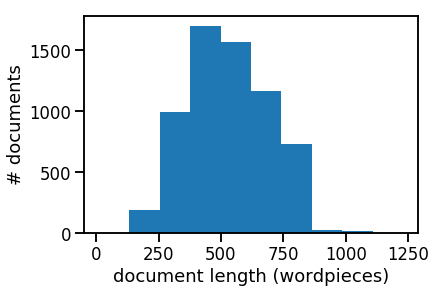

In [217]:
# plt.fig()
plt.hist(sample_lengths)
plt.savefig('lenghth_distribution.png')
plt.xlabel('document length (wordpieces)')
plt.ylabel('# documents')

## Check for UNK tokens

In [218]:
np.unique(train_dataset[0]['input_ids'])

array([  101,   102,  1010,  1014,  1015,  1016,  1017,  1018,  1019,
        1020,  1021,  1022,  1023,  1024,  1041,  1044,  1045,  1996,
        1997,  1998,  1999,  2001,  2003,  2004,  2006,  2007,  2011,
        2014,  2015,  2019,  2021,  2023,  2024,  2025,  2030,  2031,
        2036,  2038,  2045,  2047,  2051,  2053,  2060,  2070,  2072,
        2085,  2098,  2140,  2157,  2184,  2187,  2193,  2235,  2286,
        2297,  2302,  2319,  2324,  2334,  2340,  2345,  2382,  2385,
        2389,  2459,  2475,  2512,  2517,  2557,  2566,  2570,  2598,
        2620,  2638,  2692,  2695,  2717,  2772,  2828,  2854,  2861,
        2865,  2896,  2904,  2922,  2946,  2964,  3022,  3058,  3085,
        3108,  3126,  3130,  3189,  3311,  3350,  3356,  3366,  3438,
        3445,  3447,  3486,  3490,  3526,  3550,  3560,  3570,  3623,
        3630,  3642,  3760,  3904,  3998,  4005,  4090,  4226,  4229,
        4246,  4252,  4293,  4295,  4413,  4456,  4464,  4502,  4642,
        4663,  4700,

In [219]:
tokenizer.tokenizer.unk_token

'[UNK]'

In [220]:
tokenizer.tokenizer.cls_token

'[CLS]'

In [221]:
tokens = tokenizer.tokenizer.convert_ids_to_tokens(train_dataset[0]['input_ids'])

In [222]:
tokens[0:10]

['[CLS]', 'exam', 'number', ':', 'a1', '##37', '##38', '##0', '##8', '##2']

In [223]:
tokens.count(tokenizer.tokenizer.unk_token)

0

In [224]:
data_set=val_dataset
# data_set=train_dataset
number_of_UNK_list=[]
for i in range(len(data_set)):
    tokens = tokenizer.tokenizer.convert_ids_to_tokens(data_set[i]['input_ids'])
    s=tokens.count(tokenizer.tokenizer.unk_token)
    number_of_UNK_list.append(s)

In [225]:
sum(number_of_UNK_list)

0

## get embeddings

In [226]:
# from model.bert_model_utils import TorchDataset, BertForLongSequenceClassification
from transformers import BertModel

In [227]:
model = BertModel.from_pretrained(bert_model_name)

In [228]:
input_ids = val_dataset[0]['input_ids'].unsqueeze(0) 
ret_validation  = model(input_ids)

In [229]:
ret_validation[0].shape

torch.Size([1, 414, 128])

In [230]:
ret_validation[1].shape

torch.Size([1, 128])